<a href="https://colab.research.google.com/github/jameelahalrawi/matter-js/blob/master/ise043_tsaf_2526f_2_stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nsydn/ise043_tsaf/blob/2526f/ise043_tsaf_2425f_2_stationarity.ipynb)

# Stationarity

## Introduction

- Previously, we learned that time series is data that is measured at equally-spaced intervals.
- We also learned that time series data can be decomposed into three parts: trend, seasonality, and residuals.
- Now we'll dig deeper by discussing an important concept called **stationarity**.
- Having a firm grasp of this concept will lay the foundation necessary to understand more advanced modeling strategies that we'll introduce later on.

In this lecture we will cover
- Definition of stationarity and examples of common stationary and nonstationary time series.
- How to detect stationarity.
- The most common ways to transform nonstationary time series into stationary ones.

In [146]:
# Imports
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
# from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
np.random.seed(0) # Reproducibility

In [147]:
def ts_plot(x,y,title,xlabel="Time",ylabel="Value"):
    plt.figure(figsize=(10,5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

In [148]:
def acf_plot(ts,lags=30):
    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.show()

---

## Stationary Time Series

### Why is stationarity important?

- Stationarity is a fundamental assumption in many time series forecasting models.
- Without it many basic time series models would break.
- Transformations can be applied to convert a nonstationary time series to a stationary one.
- There are advanced time series models that can handle nonstationary data (beyond the scope of this lecture).

### What is stationarity?

- 💡 Intuition: a time series is stationary when there are no changes in the underlying mechanism that generates it.
- In the following, we define:
    - Strict stationarity.
    - Weak stationarity.
    - Things to check in practice.

#### Strict stationarity

<!-- - A time series $X(t): t \in \mathcal{T}$ is called strictly stationary if, for all $t_1, t_2, \dots, t_n \in \mathcal{T}$ and $h$ such that $t_1+h, t_2+h, \dots, t_n+h \in \mathcal{T}$, it holds that -->

- A time series $X(t): t \in \mathcal{T}$ is called strictly stationary if

$$\big(X(t_1),X(t_2), \dots, X(t_n)\big) \stackrel{\text{D}}{=} \big(X(t_1+h),X(t_2+h), \dots, X(t_n+h)\big)$$

where $\stackrel{\text{D}}{=}$ indicates that the distributions are equal.
- In plain words, the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- **Strict stationarity** is very difficult to verify, especially from a limited amount of data.
- For this reason, we focus on **weak stationarity**.

<!-- #### Weak stationarity

- A time series $X$ is weakly stationary if:

  1. The mean is constant over time $\mathbb{E}[X(t)] = m, \;\; \forall t \in \mathcal{T}$
  2. The variance is finite $\mathbb{E}[X(t)^2] < \infty, \;\; \forall t \in \mathcal{T}$
  3. ??? The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time. -->
 #### Weak stationary

1. Constant mean (no trend).
2. Constant variance (no heteroskedasticity).
3. Constant autocorrelation structure.
4. No periodic component (✋ careful here)

- Strict stationarity implies weak stationarity, but not the opposite.

- Mean, variance, and periodic component (or, seasonality) should be familiar from the previous lecture.
- Autocorrelation may not be.
- Let's start with a simple example of a stationary time series.

- First, we generate a variable `time` that defines equally-spaced time intervals.
- Then we'll sample values from a Normal distribution with a mean of 0 and a standard deviation of 1.
- Essentially we're creating **white noise**, which is a stationary time series as it exhibits all the properties required of a stationary time series.

In [149]:
time = np.arange(200)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))
stationary_mean, stationary_std = stationary.mean(), stationary.std()

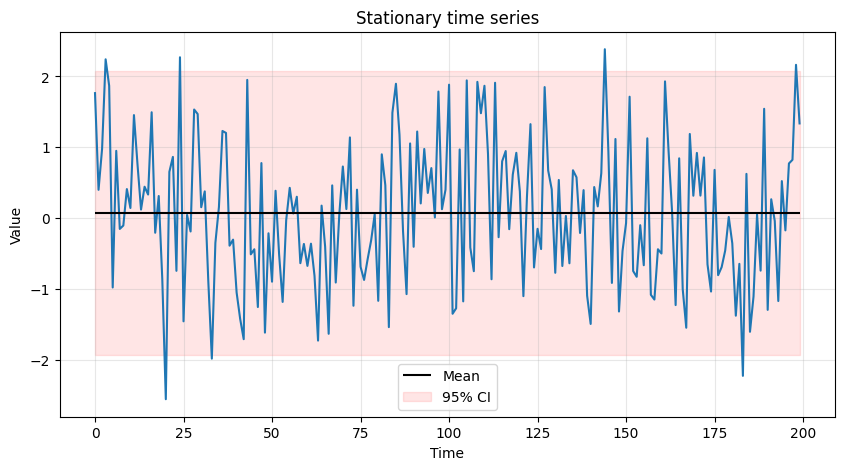

In [150]:
ts_plot(time, stationary, 'Stationary time series')
plt.hlines(stationary_mean, xmin=time[0], xmax=time[-1], colors='k', label="Mean");
plt.fill_between(time, stationary_mean-1.96*stationary_std, stationary_mean+1.96*stationary_std,
                 color='red', alpha=0.1, label='95% CI')
plt.legend();

- We can visually confirm that the white noise has constant mean, constant variance, and no periodicity.
- What about the **autocorrelation**?

#### Autocorrelation
- Autocorrelation measures how much the current time series measurement is correlated with a past measurement (i.e., lags).
- For example, today's temperature is often highly correlated with yesterday's temperature.
- Autocorrelation often results in a pattern, whereas a time series without autocorrelation looks random.

<!-- **Example: Constant auto-correlation**
* during a period of market stability, the stock prices might show a consistent pattern over time -->

An example to auto-correlated process

In [151]:
# import statsmodels as sm
# arma = arma_generate_sample([1,-0.75], [1], 250)
# fig, ax = plt.subplots(1,2, figsize=(10, 3))
# plot_acf(arma, lags=50, ax=ax[0])
# plot_pacf(arma, lags=50, ax=ax[1])
# plt.show()

### Common stationary and nonstationary time series

- If the analytic expression of the time series is known, it is possible to check the conditions for stationarity.
- In practice, the process generating the time series might be unknown and we'll need other tools to check stationarity.
- Starting the analysis by looking at the `run_sequence_plot` is an excellent starting point.

#### White noise

- We already looked at this time series and conclude that mean and variance are constant and there is no seasonal component.
- In addition, since the random value at each time step is drawn independently, there is no correlation.

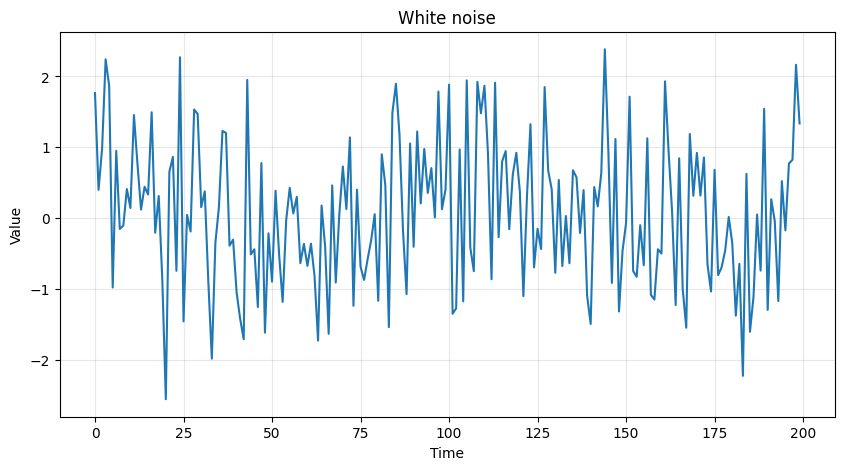

In [152]:
ts_plot(time, stationary, 'White noise')

#### Random walk

- The random walk is one of the most important nonstationary time series.
- It is defined as:
$$X(t) = X(t-1) + \epsilon_t$$  
- where $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$ are called *innovations* (or *residuals*) and are i.i.d. (independent and identically distributed).
- Let's create a random walk.

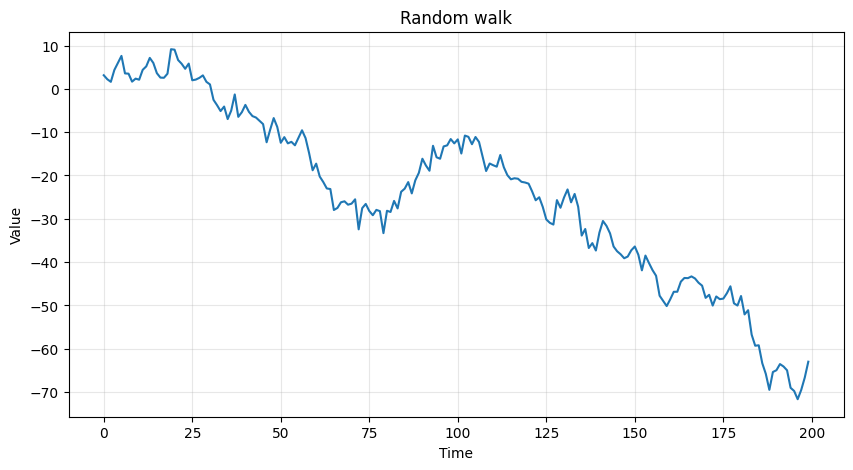

In [153]:
state = np.random.get_state()

# empty series
rand_walk = np.empty_like(time, dtype='float')

# initial value
rand_walk[0] = 3.14

# Random Walk
for t in time[1:]:
    rand_walk[t] = rand_walk[t-1] + np.random.normal(loc=0, scale=2.5, size=1)[0]

ts_plot(time, rand_walk, 'Random walk')

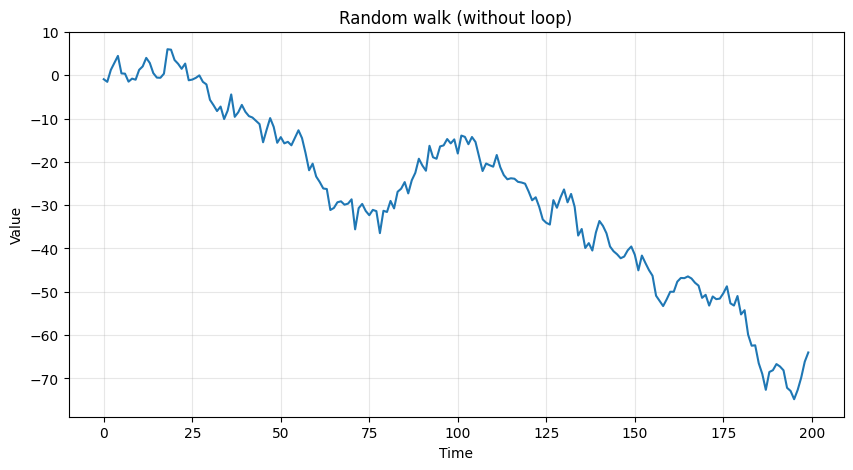

In [154]:
np.random.set_state(state)
ts_plot(time, np.cumsum(np.random.normal(loc=0, scale=2.5, size=200)),'Random walk (without loop)')

- Notice:
>* how the current value is highly correlated with the past values
>* how this causes a trend (non-constant mean)
- The random walk is obviously nonstationary.
<!-- - Why 🤔? -->

<!-- **Dependence on Initial Value**

- The value of the series at any timepoint depends on its initial value and the sum of all previous innovations.
- Clearly, this path dependence implies non-stationarity. -->

<!-- **Changing variance**

- In a random walk, the variance increases linearly over time because the effects of the innovations accumulate.
- This violates condition #2 of weak stationarity.
- Let's see this in detail. -->

<!-- At a general time $t$ we have:
   - $X(t) = X(t-1) + \epsilon_t = X(0) + \epsilon_1 + \epsilon_2 + \ldots + \epsilon_t$,
   - Using the independence of the $\epsilon$ terms and the fact that each has variance $\sigma^2$ we get
   
   $$\text{Var}(X(t)) = \text{Var}(\epsilon_1) + \text{Var}(\epsilon_2) + \ldots + \text{Var}(\epsilon_t) = t\sigma^2$$ -->

#### Time series with trend

- Consider the following data.

In [155]:
trend = (time * 2.65) + stationary*10

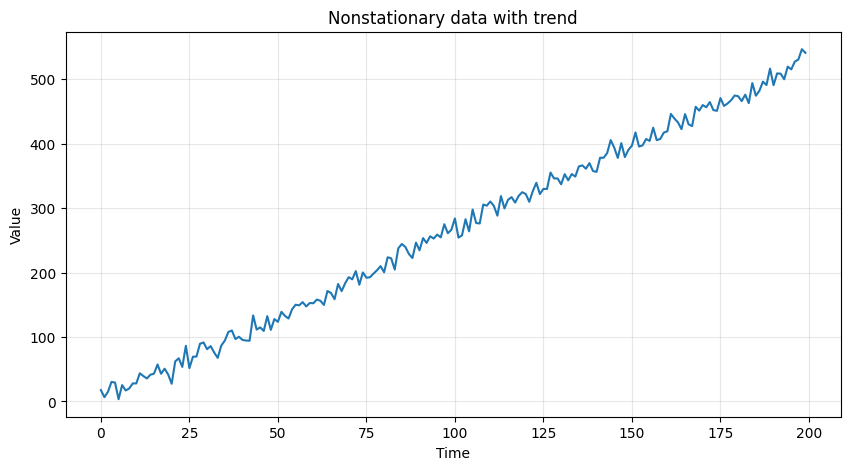

In [156]:
ts_plot(time, trend, 'Nonstationary data with trend')

  - Is this data stationary?

- No, the mean changes over time and violates condition #1.

#### Heteroscedastic time series

In [157]:
part1 = np.random.normal(loc=0, scale=1.0, size = 100)
part2 = np.random.normal(loc=0, scale=10.0, size = 100)
heteros = np.append(part1, part2)

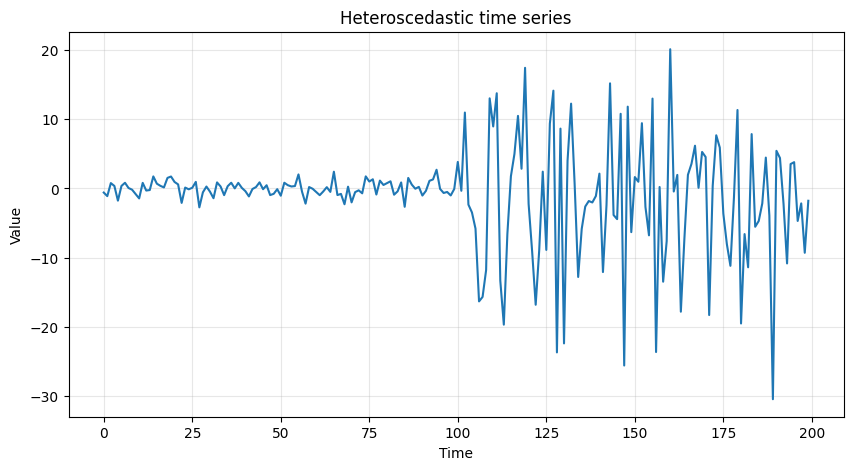

In [158]:
ts_plot(time, heteros, 'Heteroscedastic time series')

- Is this data stationary?

- No, the variance changes over time.

#### Time series with seasonality

In [159]:
seasonality = 20 + np.sin(2*np.pi*time/12)*20

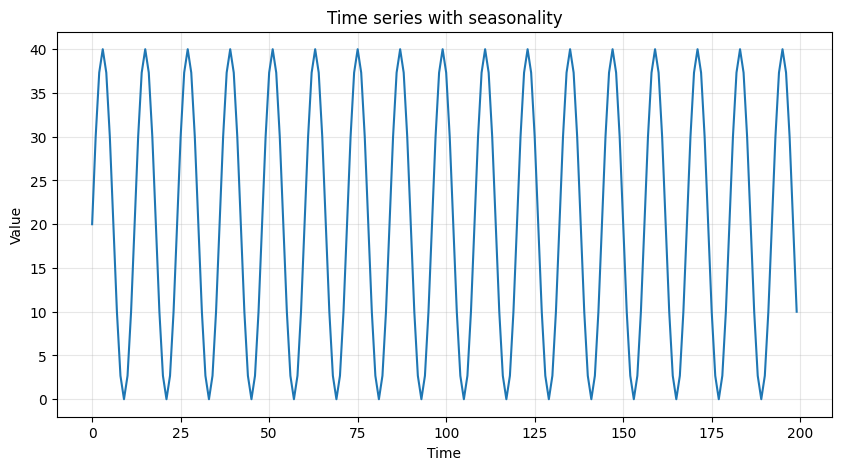

In [160]:
ts_plot(time, seasonality,"Time series with seasonality")

- Is this time series stationary?

- The mean of a periodic signal over a complete cycle always assumes the same value (`20` in our case).
- However, over an half-cycle or any period not equal to an integer multiple of the full cycle, the mean changes (is different from `20`).
- This violates condition #1.

<img src="https://github.com/nsydn/ise043_tsaf/blob/main/media/periodic_mean.png?raw=1" style="width: 60%; display: block; margin: auto;">

- Similarly, the variance depends on the time interval over which it is measured.
- Since the signal's amplitude varies, the variance calculated over different phases of the sinusoid will also vary.
- This violates condition #2.
- A similar argument also hold for the autocorrelation, which violates condition #3.

- So, no, the time series is not stationary.

#### Time series with trend and seasonality

In [161]:
trend_seasonality = trend + seasonality + stationary

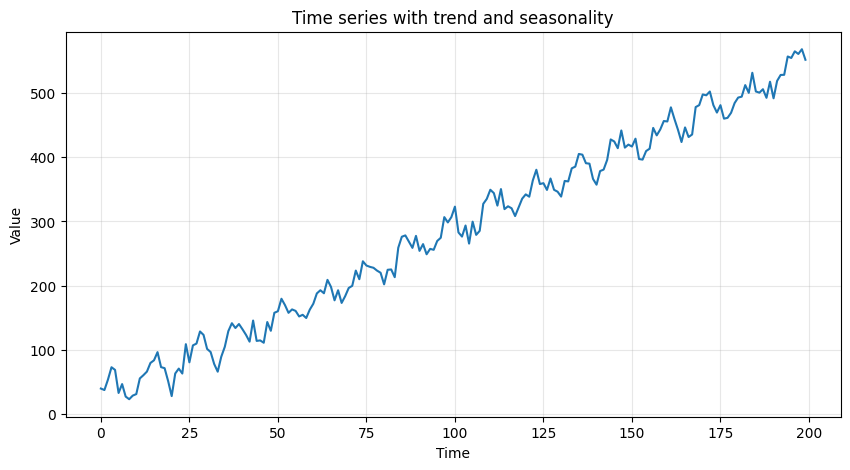

In [162]:
ts_plot(time, trend_seasonality,"Time series with trend and seasonality")

- Is this data not stationary?

- No, the mean changes over time because of the trend AND there is a periodic component.

## Detecting stationarity

Next, we will review practical techniques used to identify if a time series is stationary or not.

Specifically, we will cover:
1. Time plots
2. Summary statistics
3. Histogram plots
4. Augmented Dickey-Fuller test

### Time Plots

- Run time plots allows to visualize what's happening with the data.
- This should always be your starting point.
- Indeed, that is what we have been doing so far with our function `ts_plot()`.
- It often shows whether there is an underlying structure (trend, seasonality, or autocorrelation).

### Summary Statistics

- An easy way to check for constant mean and variance is to split the data into separate chunks.
- Then, calculate statistics for each chunk, and compare them.
- Large deviations in either the mean or the variance among chunks might indicate that the time series is nonstationary.
- It's not a rigorous method but gives a good hint of whether the data is approximately stationary or not.

<img src="https://github.com/nsydn/ise043_tsaf/blob/main/media/stationary_chunk.png?raw=1" width=800; style="width: 50%; display: block; margin: auto;">

<img src="https://github.com/nsydn/ise043_tsaf/blob/main/media/nonstationary_chunk.png?raw=1" width=800; style="width: 50%; display: block; margin: auto;">

- Let's look at an example based on the `trend` time series that we created before.

In [163]:
# split data into 10 chunks
chunks = np.split(trend, indices_or_sections=10)

In [164]:
chunks[0]

array([17.64052346,  6.65157208, 15.08737984, 30.35893199, 29.2755799 ,
        3.4772212 , 25.40088418, 17.03642792, 20.16781148, 27.95598502,
       27.94043571, 43.69273507, 39.41037725, 35.66675016, 41.53863233,
       43.08674327, 57.34079073, 42.99841736, 50.83067702, 41.80904261])

* Get summary statistics for each chunk:

In [165]:
# compare means and variances
for i, chunk in enumerate(chunks, 1):
    print(i, 'mean: %.2f, var: %.2f' % (np.mean(chunk), np.var(chunk)))

1 mean: 30.87, var: 200.30
2 mean: 78.73, var: 401.12
3 mean: 127.22, var: 370.71
4 mean: 180.65, var: 336.65
5 mean: 241.39, var: 373.20
6 mean: 295.14, var: 426.58
7 mean: 343.87, var: 265.73
8 mean: 395.81, var: 262.11
9 mean: 449.28, var: 251.53
10 mean: 500.87, var: 575.75


- While the variance is relatively constant over time, the mean is clearly changing, which means this data is not stationary.
- We do expect some fluctuation in values. Mean or variance will not be exactly the same from chunk to chunk, but the values should be close.

- To see this better, it's a good idea to plot the means and variances.

In [166]:
chunks_heteros = np.split(heteros, indices_or_sections=10)
for i, chunk in enumerate(chunks_heteros,1):
    print(i, 'mean: %.2f, var: %.2f' % (np.mean(chunk), np.var(chunk)))

1 mean: 0.14, var: 0.91
2 mean: -0.11, var: 0.98
3 mean: -0.09, var: 0.77
4 mean: -0.12, var: 1.35
5 mean: 0.11, var: 1.30
6 mean: -0.37, var: 116.58
7 mean: -3.34, var: 105.84
8 mean: -2.19, var: 119.45
9 mean: 0.04, var: 82.20
10 mean: -4.29, var: 79.12


In [167]:
chunks_stationary = np.split(stationary, indices_or_sections=5)
for i, chunk in enumerate(chunks_stationary,1):
    print(i, 'mean: %.2f, var: %.2f' % (np.mean(chunk), np.var(chunk)))

1 mean: 0.31, var: 1.13
2 mean: -0.37, var: 0.66
3 mean: 0.46, var: 1.09
4 mean: 0.02, var: 0.85
5 mean: -0.06, var: 1.06


### Histogram Plot

- Plotting a histogram of the time series gives important clues into its underlying structure.
- An histogram that looks like a Normal distribution suggests that mean and variance are constant.

- Let's start from the non-stationary time series with trend.

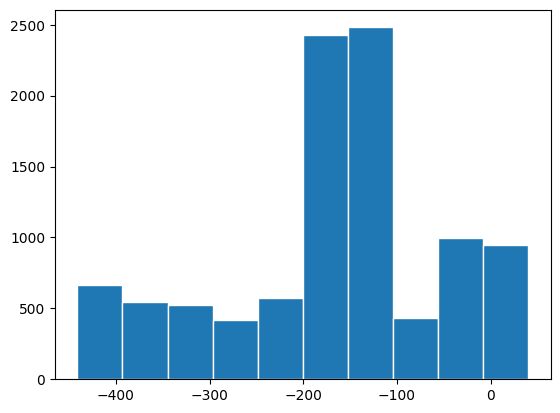

In [168]:
# pd.Series(trend).hist(figsize=(7,3));
plt.hist(np.cumsum(np.random.normal(loc=0, scale=2.5, size=10000)), edgecolor='w');

- The histogram resembles an *uniform* distribution.
>- It doesn't have to be *uniform* though
- This is expected since `trend` is, indeed, not stationary.

- Let's try the same thing on the `stationary` data we created at the beginning.

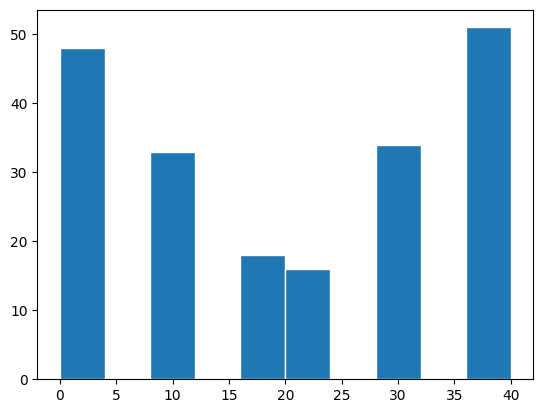

In [169]:
plt.hist(seasonality, edgecolor='w');
# what about rand_walk?

- That definitely looks more approximately Normal.
<!-- - To be more precise, we could use SciPy's [normaltest](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mstats.normaltest.html) to test how much the histogram differs from a Normal distribution. -->

### Augmented Dickey-Fuller (ADF) Test

- This is a statistical procedure to determine whether a time series is stationary or not.
- We will discuss more details about the test in the next lectures
- For now, that's what we need to know:
>* **Null hypothesis ($H_0$):** the series is non-stationary.
>* **Alternative hypothesis ($H_1$):** the series is stationary.

- Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.
- The values $\alpha=0.05$ or $\alpha=0.01$, which yield a confidence of $95\%$ and $99\%$, respectively, are common choices.
<!-- Explain the paradox behind increasing confidence level -->

Example: $p = 0.0001 \rightarrow$ reject $H_0 \rightarrow$ the time series is stationary

Example: $p = 0.43 \rightarrow$ fail to reject $H_0 \rightarrow$ the time series is non-stationary

- **The ADF test might be inaccurate with small datasets or when heteroskedasticity is present.**
- It is best to pair ADF with other techniques (time plots, summary statistics, histograms, etc..).**

#### Stationary Data & ADF

- Let's see how to run this test in Python.

In [170]:
from statsmodels.tsa.stattools import adfuller
testval, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationary)

- Let's see and comment the main outputs from the ADF test.

In [171]:
testval, pvalue

(np.float64(-13.56203402252643), np.float64(2.300172138070656e-25))

- The more negative the test statistic, the more confident we can be that the series is stationary.
- The `pvalue` is interpreted like any p-value.
- The `pvalue` should be compared with the confidence levels (e.g., $\alpha=0.05$ or $\alpha=0.01$).
- Based on the comparison, we reject or fail to reject $H_0$.
- Here ``pvalue`` is very close to zero so we **reject** the $H_0$ in favor of $H_A$ and conclude that the time series is stationary.

In [172]:
critical_values

{'1%': np.float64(-3.4636447617687436),
 '5%': np.float64(-2.8761761179270766),
 '10%': np.float64(-2.57457158581854)}

- Finally, ``critical_values`` are the test statistic thresholds for common significant levels.
- Here we see a test statistic lower than -2.87 is sufficient to reject $H_0$ at a significance level of 5%.

- See [statsmodels docs](http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for a description of ``usedlag`` and ``icbest``.

#### ADF on time series with trend
- Next, we run the ADF test on the `trend` time series.

In [173]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(trend)
testval, pvalue

(np.float64(-13.56203402252643), np.float64(0.9907762137001896))

- As expected, we fail to reject $H_0$ that the time series `trend` is non-stationary.

### ADF on random walk

- Finally, we run the ADF test on the `rand_walk` time series.

In [174]:
testval, pvalue, usedlag, nobs, critical_values, icbest = adfuller(rand_walk)
testval, pvalue

(np.float64(-0.07427886384893519), np.float64(0.9519409551210902))

- As we discussed before, the random walk is non-stationary because its variance is not constant over time.
- In the next section, we'll learn how to make this time series stationary.

- Good news 😎. At this point, we have several tools at our disposal to figure out if a time series is stationary or not.

---

## Common transformations to achieve stationarity

- There are several ways to transform nonstationary time series data:

Transformation | Effect
:---|:---
Subtract trend | Constant mean
Apply log | Constant variance
Differencing | Remove autocorrelation
Seasonal differencing | Remove periodic component

- Often you will have to do several of these on one dataset.
- Note that this is just a small subset of the total possible ways to transform nonstationary time series.

### Subtract estimated trend & seasonality

- Let's run the ADF test before transforming.

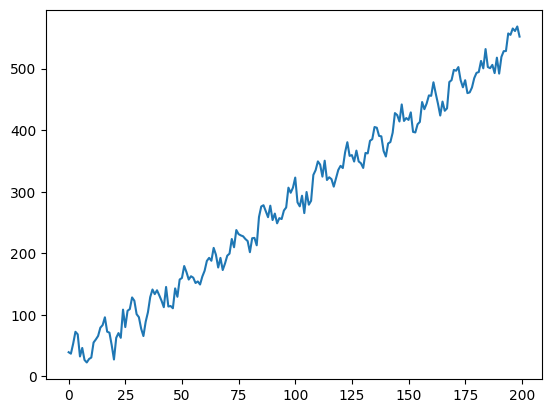

In [175]:
plt.plot(trend_seasonality)

In [176]:
testval_before, pvalue_before, _, _, _, _ = adfuller(trend_seasonality)
testval_before,pvalue_before

(np.float64(0.9652811583652313), np.float64(0.993885775555557))

- Non-stationary as expected.
- Next, we apply the transformation.

In [177]:
trend_seasonality_decompose = seasonal_decompose(x=trend_seasonality, model='additive', period=12, extrapolate_trend=1)
est_trend = trend_seasonality_decompose.trend
est_seasonal = trend_seasonality_decompose.seasonal
est_residual = trend_seasonality_decompose.resid

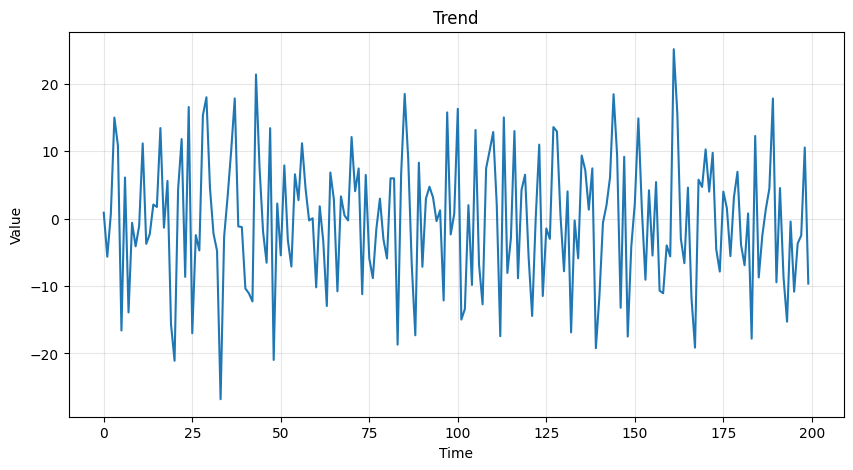

In [178]:
ts_plot(time, est_residual, 'Trend')

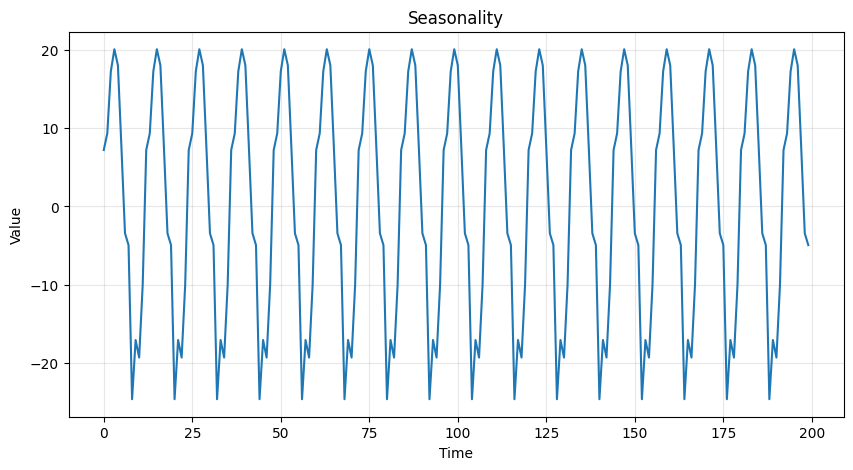

In [179]:
ts_plot(time, est_seasonal, "Seasonality")

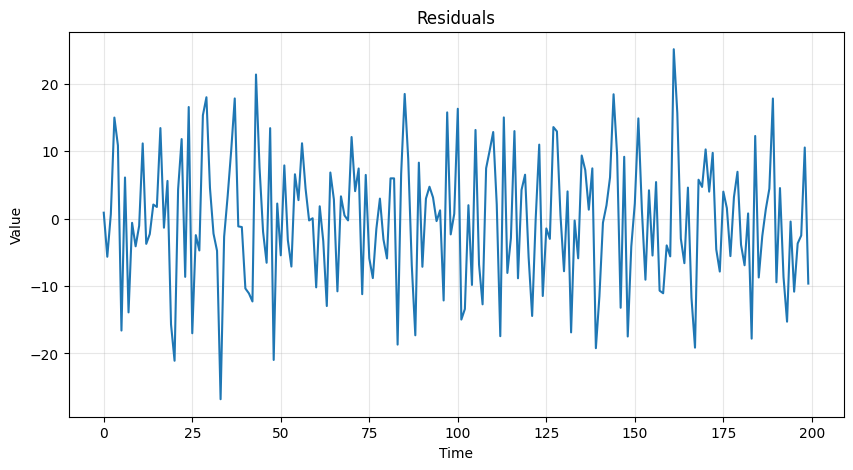

In [180]:
ts_plot(time, est_residual, "Residuals")

- Let's look at the residual values.

<!-- - We'll have to remove the first $6$ and last $6$ values to run an ADF test since those are `nan`.
- The number 6 is due to the fact that the method applies seasonal differencing and we specified `period=12`.
- Here's how to do that and run the test all in one call. -->

In [181]:
testval_after, pvalue_after, _, _, _, _ = adfuller(est_residual)
testval_after, pvalue_after

(np.float64(-6.917732511914052), np.float64(1.1677085417434424e-09))

- Now the time series is stationary ✌.

### Stabilize variance with log transform

- This trick is useful when dealing with heteroskedastic data.
- The log squashes the parts of the time series where the variance is higher.
- In this way, the variance becomes more uniform.
- Let's plot again the heteroskedastic times series to remember how it looks.

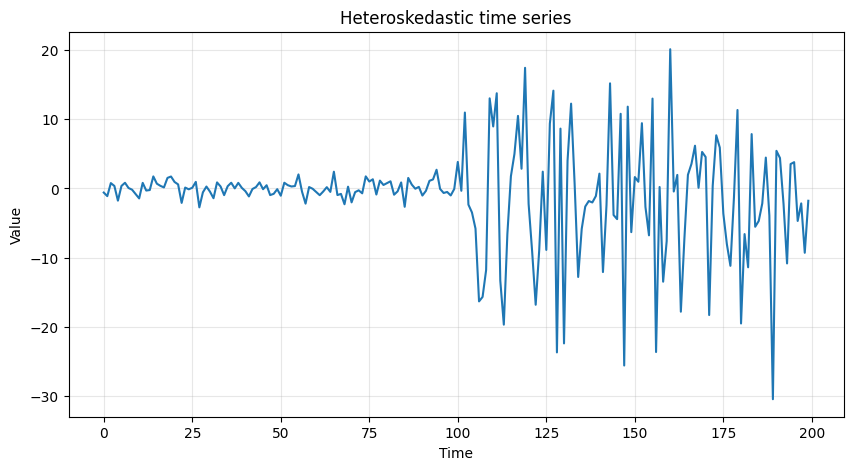

In [182]:
ts_plot(time, heteros, title="Heteroskedastic time series");

- Let's run the ADF test.

In [183]:
testval_before, pvalue_before, _, _, _, _ = adfuller(heteros)
testval_before, pvalue_before

(np.float64(-3.6559628997407723), np.float64(0.004776985689480664))

**⚠ Attention ⚠**

- ADF is saying we reject $H_0$ (at least at $\alpha=0.05$ confidence level) in favor of the alternative that the time series is stationary.
- However, the plot clearly shows that the variance is not constant over time.  

- This is an important lesson.
- Some statistical tests like ADF perform bad in some situations:
    - with few data,
    - when data is heteroskedastic.

- Let's now apply the log transformation.
- Don't forget that `log` will not accept negative values.
- Therefore, we shift the time series up a little bit ensure that all values are positive.

In [184]:
# Ensure all data are positive
heteros_shifted = heteros + abs(heteros.min()) + 1

# Apply the log
log_heteros_shifted = np.log(heteros_shifted)

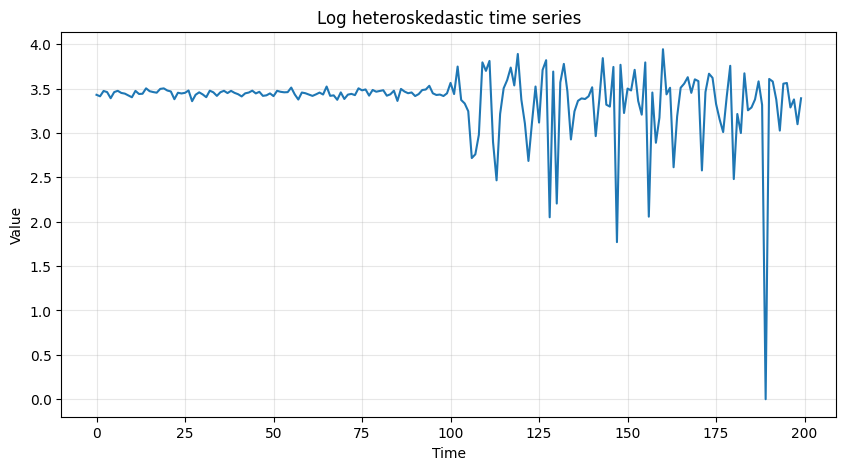

In [185]:
ts_plot(time, log_heteros_shifted, title="Log heteroskedastic time series");

- Look at the values on the $y$ axis.
- Notice how the variance has collapsed to a large extent.

📨 **Takeaway message:**

- **The ADF test can fail to detect nonstationarity due to heteroskedasticity.**
- **Always plot the data.**
- **Do not rely on a single tool to determine stationarity.**

### Removing autocorrelation with differencing

- Remember that the ADF test (correctly) indicated that the `rand_walk` time series is non-
stationary.
- We can transform `rand_walk` into stationary time series by applying differencing.
- This is done by subtracting a past value from the current value.


> *   A simple and useful way to detect auto-correlation visually is to look at auto-correlation and partial auto-correlation graphs, namely, **ACF and PACF**.
> * A slow decay in the ACF and a sharp cut-off in PACF implies auto-correlation (thus, non-stationarity) in time series



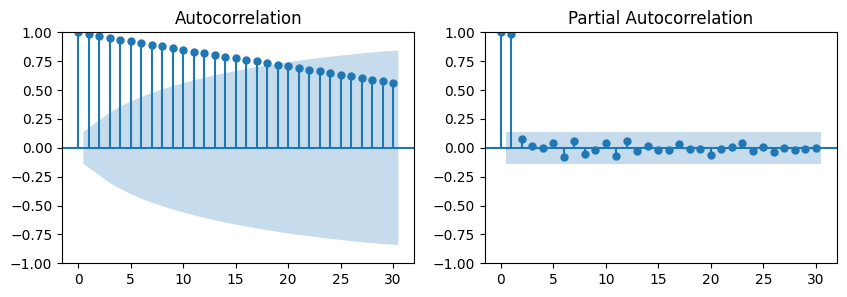

In [186]:
acf_plot(trend)

- We know that `rand_walk` was created with a lag of 1.
- It is expected that the `rand_walk` has auto-correlation at lag 1.
- So, `rand_walk` can be converted to a stationary time series by taking the first difference:

$$\hat{X}(t) = X(t) - X(t-1)$$

In [187]:
rand_walk_diff = np.diff(rand_walk)
# difference = rand_walk[1:] - rand_walk[:-1]

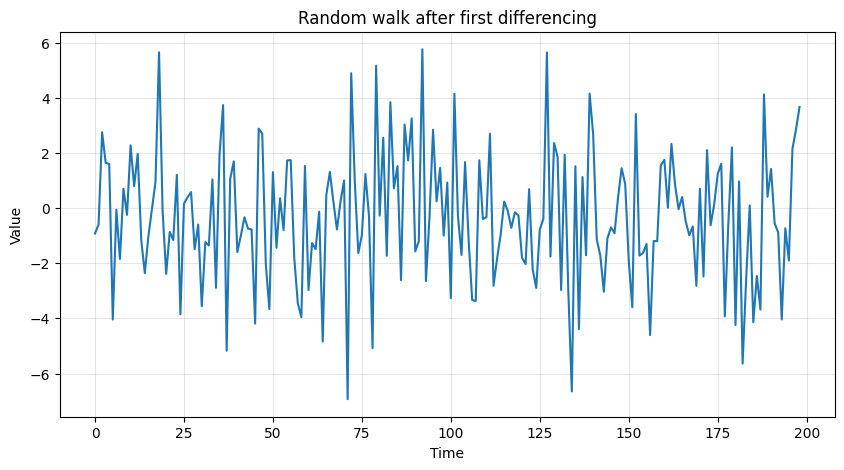

In [188]:
ts_plot(time[:-1], rand_walk_diff, title="Random walk after first differencing");

- Let's run ADF on the differenced data.

In [189]:
testval_after, pvalue_after, _, _, _, _ = adfuller(rand_walk_diff)
testval_after, pvalue_after

(np.float64(-15.709756251140702), np.float64(1.364041505397375e-28))

- Now it's stationary!

### Seasonal differencing

- Consider a time series with a seasonality of period $L$.
- There will be a strong correlation between $X(t)$ and $X(t+L)$.
- Seasonal differentiation can remove the seasonality and make the time series stationary

$$\hat{X}(t) = X(t+L) - X(t)$$

- After seasonal differencing the time series will become $L$ steps shorter.
- Note that we can perform the standard differentiation in cascade to seasonal differentiation if we need to remove also the trend on top of the seasonality.
- Let's see this on the `trend_seasonality` time series.

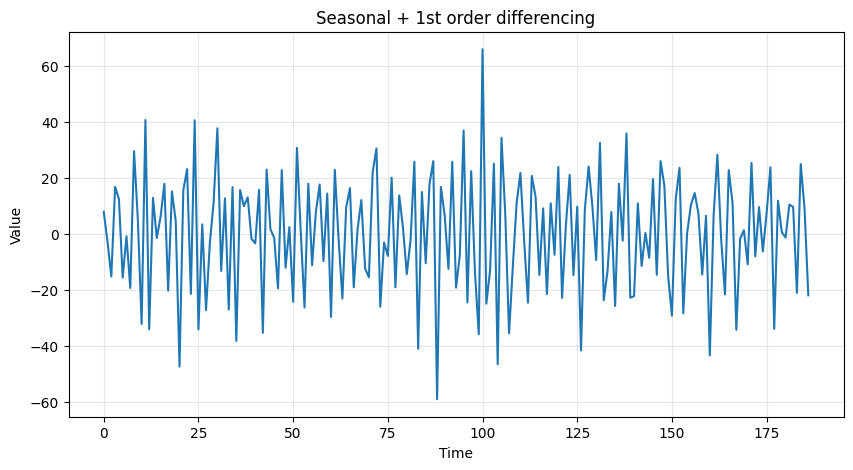

In [190]:
trend_seasonality_L12 = trend_seasonality[12:] - trend_seasonality[:-12]  # remove seasonality
trend_seasonality_L12_diff = np.diff(trend_seasonality_L12)

# Plot the differenced time series
ts_plot(time[:-13], trend_seasonality_L12_diff, title="Seasonal + 1st order differencing");

In [191]:
testval_after, pvalue_after, _, _, _, _ = adfuller(trend_seasonality_L12_diff)
testval_after, pvalue_after

(np.float64(-5.2823054354045995), np.float64(5.957203780187507e-06))

---

## Summary

In this lecture we learned:
1. What does it mean for a time series to be stationary.
2. A set of notable stationary and nonstationary time series.
2. Common tools to identify stationarity.
3. Useful nonstationary-to-stationary transformations.

---

## Exercises

### Exercise 1

- Load the two time series `stationarity_ts1` and `stationarity_ts2` by running the code below.

=== stationarity_ts1 ===
count    100.000000
mean       0.042972
std        5.701213
min      -24.004536
25%       -1.174821
50%        0.297177
75%        1.277507
max       23.909605
dtype: float64 

=== stationarity_ts2 ===
count    100.000000
mean      24.530208
std       13.279965
min       -1.234296
25%       16.359165
50%       23.727371
75%       30.949220
max       48.006154
dtype: float64 



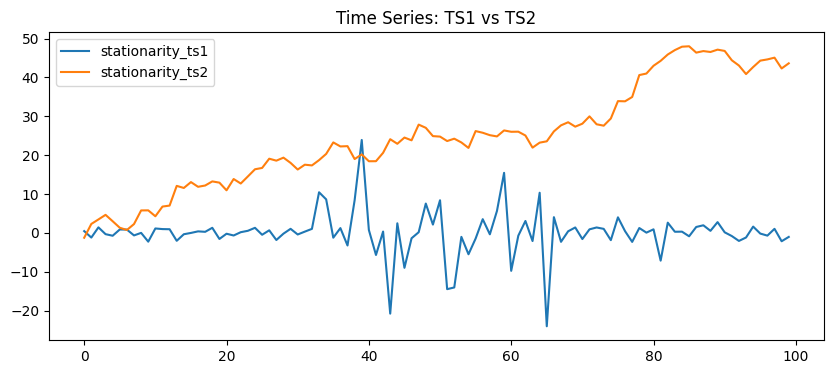

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO


response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts1.npy?download=1")
response.raise_for_status()
stationarity_ts1 = np.load(BytesIO(response.content))

response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts2.npy?download=1")
response.raise_for_status()
stationarity_ts2 = np.load(BytesIO(response.content))

stationarity_ts1 = pd.Series(stationarity_ts1)
stationarity_ts2 = pd.Series(stationarity_ts2)

print("=== stationarity_ts1 ===")
print(stationarity_ts1.describe(), "\n")

print("=== stationarity_ts2 ===")
print(stationarity_ts2.describe(), "\n")
plt.figure(figsize=(10,4))
plt.plot(stationarity_ts1, label='stationarity_ts1')
plt.plot(stationarity_ts2, label='stationarity_ts2')
plt.title("Time Series: TS1 vs TS2")
plt.legend()
plt.show()

In [196]:

response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts1.npy?download=1")
response.raise_for_status()
stationarity_ts1 = np.load(BytesIO(response.content))

response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts2.npy?download=1")
response.raise_for_status()
stationarity_ts2 = np.load(BytesIO(response.content))

1. Plot the two time series.
4. Based on the plot, discuss if each time series seems to be stationary or not.

### Exercise 2

Use the following tools to determine if the time series `stationarity_ts1` and `stationarity_ts2` are stationary or not.

1. Summary statistics on the chunks.
2. Histogram plots.
3. Augmented Dickey-Fuller test.

Discuss the result obtained with each method.

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def describe_series(ts, name="series"):
    print(f"=== {name} basic info ===")
    print("Length:", len(ts))
    print("Mean:", ts.mean())
    print("Variance:", ts.var())
    print("First 5 values:\n", ts.head())
    print("Last 5 values:\n", ts.tail())
    print()

def chunk_stats(ts, name="series", chunks=4):
    """
    Split the time series into 'chunks' equal parts,
    and print mean and variance per chunk.
    """
    print(f"\n=== {name}: chunk statistics ===")
    n = len(ts)
    size = n // chunks

    for i in range(chunks):
        start = i * size
        end = (i + 1) * size if i < chunks - 1 else n
        chunk = ts.iloc[start:end]

        print(f"Chunk {i+1}: index[{start}:{end}]")
        print(f"  Mean     = {chunk.mean():.4f}")
        print(f"  Variance = {chunk.var():.4f}")
    print()

def plot_histograms(ts1, ts2, name1="TS1", name2="TS2", bins=20):
    """
    Plot histograms of the 2 series side by side
    to visually compare distribution (center/spread).
    """
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.hist(ts1, bins=bins)
    plt.title(f"Histogram: {name1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.subplot(1,2,2)
    plt.hist(ts2, bins=bins)
    plt.title(f"Histogram: {name2}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def adf_test(ts, name="series"):
    """
    Run Augmented Dickey-Fuller test and interpret.
    H0: non-stationary (has unit root)
    H1: stationary
    """
    print(f"\n=== {name}: ADF Test ===")
    result = adfuller(ts)

    adf_stat = result[0]
    p_value = result[1]
    used_lags = result[2]
    n_obs = result[3]
    crit_values = result[4]

    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value:       {p_value:.4f}")
    print(f"Lags used:     {used_lags}")
    print(f"Observations:  {n_obs}")
    print("Critical Values:")
    for k, v in crit_values.items():
        print(f"   {k}: {v:.4f}")


    if p_value < 0.05:
        print("=> Reject H0 → Series is STATIONARY ✅")
    else:
        print("=> Fail to reject H0 → Series is NON-STATIONARY ❌")
    print()

def full_stationarity_report(ts1, ts2, name1="stationarity_ts1", name2="stationarity_ts2"):

    describe_series(ts1, name1)
    describe_series(ts2, name2)

    chunk_stats(ts1, name1, chunks=4)
    chunk_stats(ts2, name2, chunks=4)

    plot_histograms(ts1, ts2, name1=name1, name2=name2, bins=20)


    adf_test(ts1, name1)
    adf_test(ts2, name2)



### Exercise 3
If either or both datasets from exercises one and two are nonstationary, apply the transformations you learned in this section to make them so. Then apply the methods you learned to ensure stationarity.

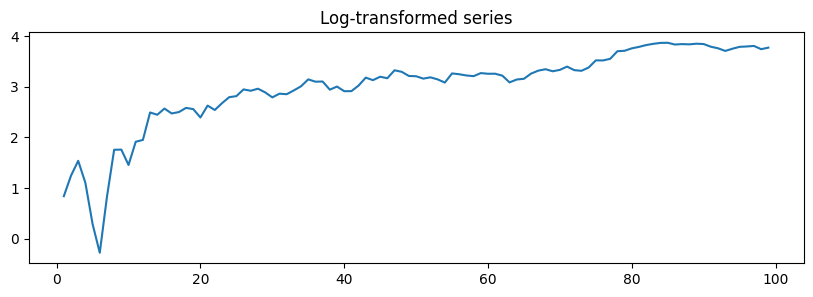

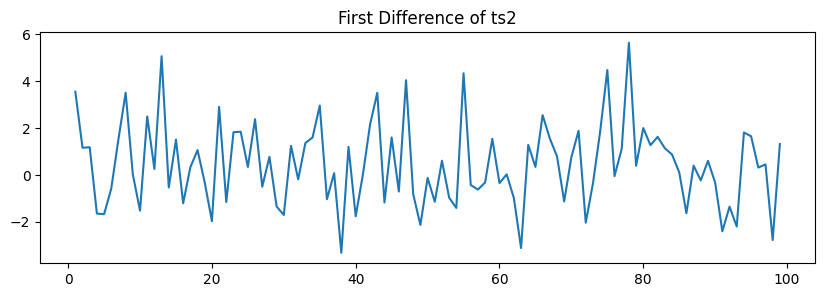

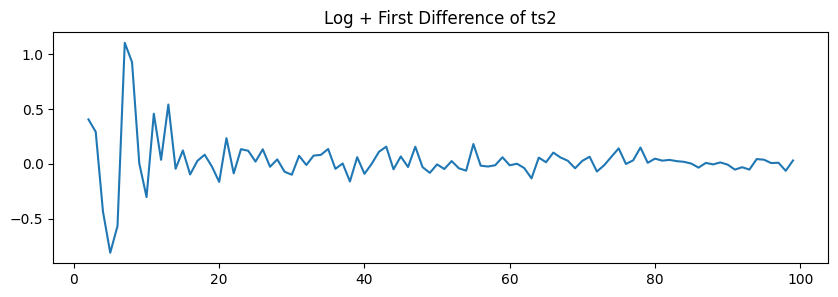


Original ts2
ADF Statistic: -1.3223
p-value: 0.6189
❌ Non-stationary

Log(ts2)
ADF Statistic: -2.1885
p-value: 0.2104
❌ Non-stationary

1st Difference(ts2)
ADF Statistic: -10.2800
p-value: 0.0000
✅ Stationary

Log + 1st Difference(ts2)
ADF Statistic: -3.9005
p-value: 0.0020
✅ Stationary


In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Ensure stationarity_ts2 is a pandas Series
stationarity_ts2 = pd.Series(stationarity_ts2)

log_ts = np.log(stationarity_ts2)

plt.figure(figsize=(10,3))
plt.plot(log_ts)
plt.title("Log-transformed series")
plt.show()

diff_ts = stationarity_ts2.diff().dropna()

plt.figure(figsize=(10,3))
plt.plot(diff_ts)
plt.title("First Difference of ts2")
plt.show()

log_diff_ts = np.log(stationarity_ts2).diff().dropna()

plt.figure(figsize=(10,3))
plt.plot(log_diff_ts)
plt.title("Log + First Difference of ts2")
plt.show()

def adf_test(ts, name="Series"):
    result = adfuller(ts)
    print(f"\n{name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("✅ Stationary")
    else:
        print("❌ Non-stationary")

adf_test(stationarity_ts2, "Original ts2")

adf_test(log_ts.dropna(), "Log(ts2)")

adf_test(diff_ts, "1st Difference(ts2)")


adf_test(log_diff_ts, "Log + 1st Difference(ts2)")